In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Artificial Life Project

**Miguel de Llanza Varona**

**234717**

Code from the original paper:
- Genewein, T., Leibfried, F., Grau-Moya, J., & Braun, D. A. (2015). Bounded rationality, abstraction, and hierarchical decision-making: An information-theoretic optimality principle. Frontiers in Robotics and AI, 2, 27.

Can be downloaded from the Github they provide:
- https://github.com/tgenewein/BoundedRationalityAbstractionAndHierarchicalDecisionMaking/tree/master/NotebooksAndCode

The functions below 'setuptaxonomy', 'U', 'setuputilityarrays', 'boltzmanndist', and 'Blahut_Arimato' are adapted, with some minor variations, from the original paper (see Githhub above), since those are implemented in Julia. 

In [ ]:
def setuptaxonomy():
    # set up taxonomy example
    # observations
    w_strings = ["Laptop","Monitor","Gamepad", #COMPUTERS
                 "Coffee machine","Vacuum cleaner","Electric toothbrush", #small APPLIANCES
                 "Grapes","Strawberries","Limes", #FRUIT
                 "Pancake mix","Baking soda","Baker's yeast","Muffin cups", #BAKING
                ]

    # num_obs = size(w_strings,1)
    num_obs = len(w_strings)
    w_vec = list(range(num_obs))

    #actions
    a_strings = ["Laptop sleeve","Monitor cable","Video game",
                 "Coffee","Vacuum cleaner bags","Brush heads",
                 "Cheese","Cream","Cane sugar",
                 "Maple syrup","Vinegar","Flour","Chocolate chips",
                 "COMPUTERS","APPLIANCES","FRUIT","BAKING","Electronics","Food"]
    # num_acts = size(a_strings,1)
    a_vec = list(range(len(a_strings)))
    
    #set up uniform p(w)
    p_w = np.ones(num_obs) / num_obs 


    #define utility function
    #(everything is hardcoded here, which is a bit hacky but will do the job)
    #the function expects integer indices
    def U(a,w):
        u_correct_w = 3
        u_correct_category = 2.2
        u_correct_supercategory = 1.6

        #correct item
        if a<14 and a==w:
            return u_correct_w
        #flour is also fine for o=muffin cups
        if w==13 and a==12:
            return u_correct_w

        #For pancake mix both FRUIT and BAKING is fine
        if w==10 and a==16:
            return u_correct_category

        #extra if-clause is required for muffin cups
        if w==13 and a==17:
            return u_correct_category

        #correct category
        if a<18:
            cat = int(w/3)
            if (a-13) == cat:
                return u_correct_category

        #correct supercategory
        supcat = int(w/6)
        if (a-17) == supcat:
            return u_correct_supercategory
        
        #separate case for a==19
        if a==19 and w==13:
           return u_correct_supercategory

        #incorrect action
        return 0
    
    return w_vec, w_strings, a_vec, a_strings, p_w, U

def setuputilityarrays(a, w, utility):
    cardinality_a = len(a) 
    cardinality_w = len(w)

    #pre-compute utilities, find maxima
    U_pre = np.zeros((cardinality_a, cardinality_w))
    Umax = np.zeros(cardinality_w)
    for i in range(cardinality_w):
      for j in range(cardinality_a):
        # print(j,i,':', utility(a[j], w[i]))
        U_pre[j,i] = utility(a[j], w[i])
      Umax[i] = max(U_pre[:,i])

    # U_pre[11,12] = 3
    # U_pre[15,9] = 2.2
    U_pre[16,12] = 2.2
    U_pre[17,12] = 0
    U_pre[18,12] = 1.6
    return U_pre, Umax

def boltzmanndist(p0, beta, distortion):
    p_boltz = p0 * np.exp(beta * distortion)
    p_boltz /= sum(p_boltz)

    return p_boltz


#This function performs Blahut-Arimoto iterations
def Blahut_Arimato(pa_init, beta, U_pre, pw, maxiter):
    pa_new = pa_init
    card_a, card_w = U_pre.shape
    pagw_new = np.zeros((card_a,card_w))

    # main iteration
    post = []
    # iter = 0 #initialize counter, so it persists beyond the loop
    for iter in range(maxiter):
        pa = pa_new
        pagw_new = np.zeros((card_a,card_w))

        for k in range(card_w):
            # update p(a|o)
            pagw_new[:,k] = boltzmanndist(pa,beta,U_pre[:,k])
            # update p(a)            
            pa_new = pa_new + (pagw_new[:,k] * pw[k])
        
        post.append(pagw_new)

        #add small value to pa_new to make sure there are no zero-entries
        #due to limited numerical precision, then re-normalize
        pa_new += np.finfo(float).eps
        pa_new /= sum(pa_new)
    
    return pagw_new, pa_new

Some data not added to the final project:
- Number of states encoded (possible recommendatios given each bought item) varies with beta.
- The prior from the possible actions (i.e., recommendations) also varies as beta changes.

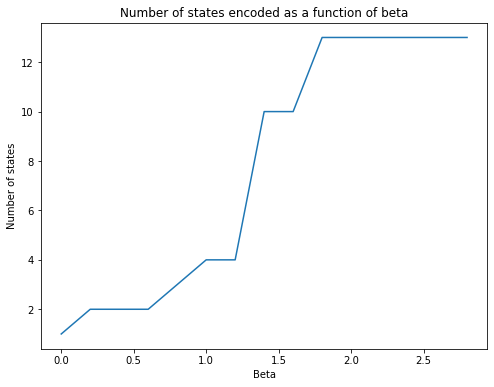

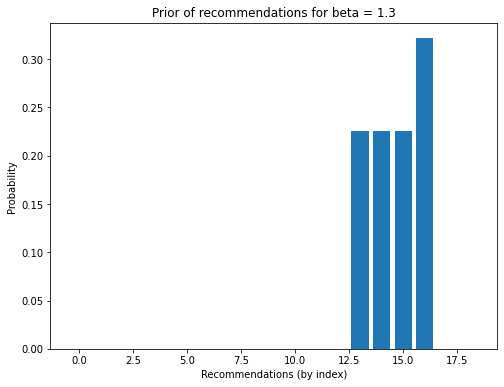

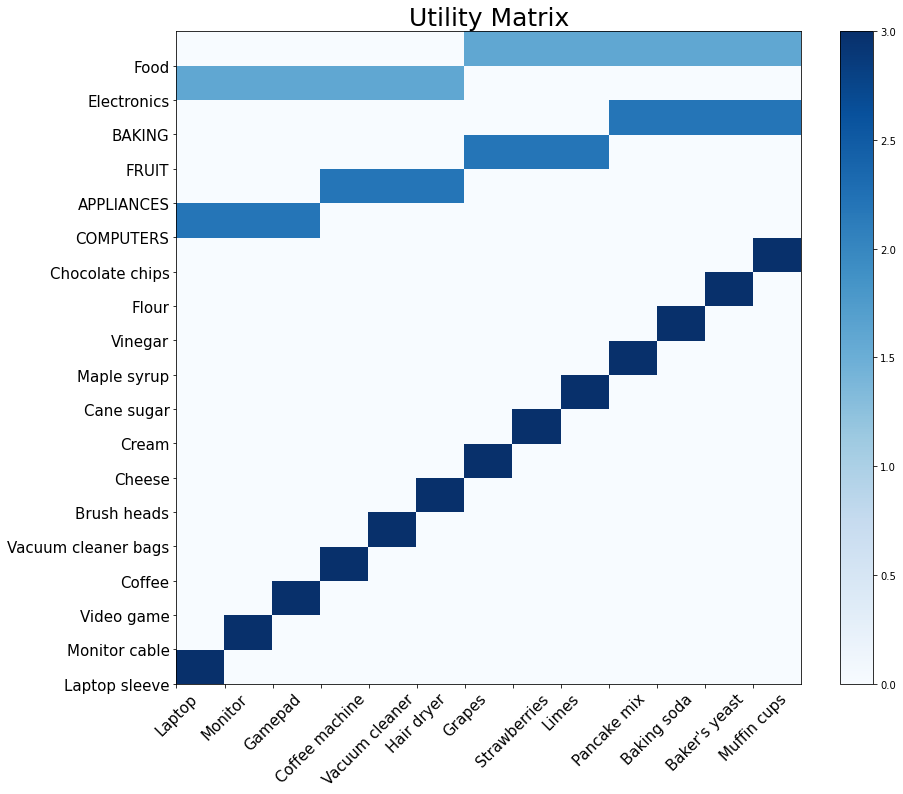

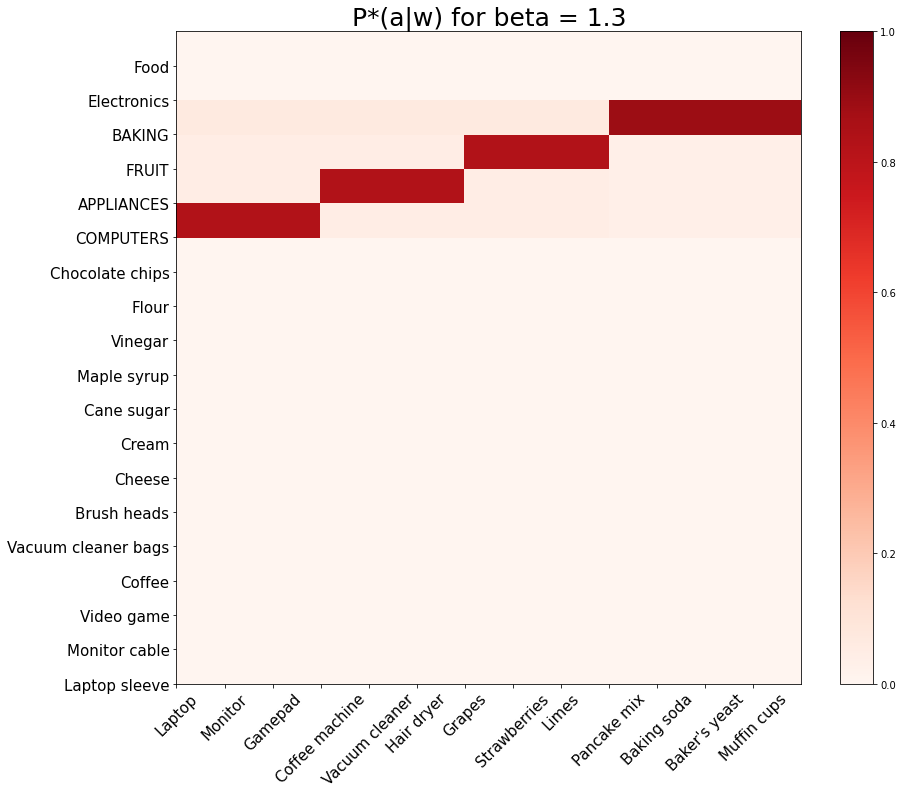

In [ ]:
w_vec, w_strings, a_vec, a_strings, p_w, U = setuptaxonomy()
U_pre, Umax = setuputilityarrays(a_vec, w_vec,U)

num_acts = len(a_vec)
pa_init = np.ones(num_acts)/num_acts 
beta = 1.3
epsilon = 0.00001 #convergence critetion for BAiterations
maxiter = 1000 #maximum number of BA iterations

p = []
betas = np.arange(0, 3, 0.2)
# betas = [0]
for b in betas:
  p_agw, p_a = Blahut_Arimato(pa_init, b, U_pre, p_w, maxiter) 
                                       
  count = 0
  for x in p_a:
    if x > 0.055:
      count += 1
    elif b == 0:
      count = 1
  p.append(count)

code_book, prior = Blahut_Arimato(pa_init, beta, U_pre, p_w, maxiter)[0], Blahut_Arimato(pa_init, beta, U_pre, p_w, maxiter)[1]

plt.figure(figsize=(8,6))
plt.plot(betas,p)
plt.title('Number of states encoded as a function of beta')
plt.xlabel('Beta')
plt.ylabel('Number of states')
plt.show()

plt.figure(figsize=(8,6))
plt.bar(list(range(len(prior))),prior)
plt.title('Prior of recommendations for beta = ' + str(beta))
plt.xlabel('Recommendations (by index)')
plt.ylabel('Probability')
plt.show()

x_labels = ["Laptop","Monitor","Gamepad", #COMPUTERS
              "Coffee machine","Vacuum cleaner","Hair dryer", #small APPLIANCES
              "Grapes","Strawberries","Limes", #FRUIT
              "Pancake mix","Baking soda","Baker's yeast","Muffin cups", #BAKING
            ]
y_labels = ["Laptop sleeve","Monitor cable","Video game","Coffee",
            "Vacuum cleaner bags","Brush heads","Cheese","Cream","Cane sugar",
            "Maple syrup","Vinegar","Flour","Chocolate chips","COMPUTERS",
            "APPLIANCES","FRUIT","BAKING","Electronics","Food"]

# Utility Matrix
fig,ax = plt.subplots(figsize=(14,12))
c1 = np.array(U_pre).reshape(19, 13)
pc1 = ax.pcolormesh(np.arange(0,14,1), np.arange(0,20,1), c1, cmap='Blues')

ax.set_xticks(list(range(len(x_labels))))
ax.set_xticklabels(x_labels, rotation=45, fontsize=15) 

ax.set_yticks(list(range(len(y_labels))))
ax.set_yticklabels(y_labels, fontsize=15)  

fig.colorbar(pc1)
plt.title('Utility Matrix', fontsize=25)
plt.show()

# Recommender system: optimal policy
fig,ax = plt.subplots(figsize=(14,12))
c2 = np.array(code_book).reshape(19, 13)
pc2 = ax.pcolormesh(np.arange(0,14,1), np.arange(0,20,1), c2, vmin=0, vmax=1, cmap='Reds')

ax.set_xticks(list(range(len(x_labels))))
ax.set_xticklabels(x_labels, rotation=45, fontsize=15) 

ax.set_yticks(list(range(len(y_labels))))
ax.set_yticklabels(y_labels, fontsize=15)  

fig.colorbar(pc2)
plt.title('P*(a|w) for beta = ' + str(beta), fontsize=25)
plt.show()

In [ ]:
def get_categories(U_pre):
  """
  Given a utility array, it returns the different existing categories by 
  grouping the indices that have the same utility value
  """
  end, start = U_pre.shape
  categories = {}
  count = 0
  for x in range(start, end):
    c = []
    for ind,value in enumerate(U_pre[x,:]):
      if value != 0:
        c.append(ind)
    categories['Category ' + str(count)] = c
    count += 1

  return categories

In [ ]:
get_categories(U_pre)

{'Category 0': [0, 1, 2],
 'Category 1': [3, 4, 5],
 'Category 2': [6, 7, 8],
 'Category 3': [9, 10, 11, 12],
 'Category 4': [0, 1, 2, 3, 4, 5],
 'Category 5': [6, 7, 8, 9, 10, 11, 12]}

In [ ]:
def evolve_environment(p, beta, U_pre, p_w, prob_mis_state, prob_mis_cat, iterations):
  """
  Computes the mean utility value and the standard deviation from utility values 
  obtianed in some number of iterations. 
  """

  p_agw, p_a = Blahut_Arimato(p, beta, U_pre, p_w, maxiter)

  categories = get_categories(U_pre)
  utils_mean = []
  utils_std = []
  utils = []

  for i in range(iterations):
    # Random state: this is the actual bought item
    state = np.random.choice(list(range(len(p_w))))

    # If there is no misperception, then simply append the value corresponding to 
    # the random state 
    rand_num = random.uniform(0,1)
    if rand_num < prob_mis_state:

      # Initialize list that will contain all possible states
      possible_states = []

      # Init list of misperceived states
      miss_states = []

      # Search for the categories in which the state is subsumed (loop through 
      # keys and list of values)
      for c,v in categories.items():
        # Items will be appended in order of category abstraction since this is
        # how I created the 'get_categories' function
        if state in v:
          possible_states.append(v)

        elif state not in v:
          if len(miss_states) < len(v):
            # Add one element from outside the list, which will correspond to
            # an element from the other supercateogry
            miss_states = v

      possible_states.sort(key=len)
      state_probs = {}
      count = 0
      for i,pos in enumerate(possible_states):
        for p in pos:
          if p not in state_probs and p != state:
            state_probs[p] = prob_mis_cat[i] / (len(pos) - 1 - count)

        count = len(pos) - 1

      # From all the elements of the other supercategory, pick one at random
      state_probs[np.random.choice(miss_states)] = prob_mis_cat[-1]

      # Get list of possible misperceived states and another list with the 
      # corresponding probability distribution
      states, probabilities = list(state_probs.keys()), np.array(list(state_probs.values()))

      # Sanity check: normalise to make sure that all probabilities add up to one
      probabilities /= probabilities.sum()

      # Pick state given the probability distribution computed above
      wrong_state = np.random.choice(states, p=probabilities)

      # Compute the average utility given the actual state and the wrong state 
      # chosen from the probability distribution. This measures the average
      # utility obtained if the actual state is missperceived.
      av_util = U_pre[:,state] @ p_agw[:,wrong_state]

      utils.append(av_util)

    else:
      av_util = U_pre[:,state] @ p_agw[:,state]
      utils.append(av_util)

  # Compute mean and standard deviation from all the results obtained in each
  # iteration
  utils_mean = np.mean(utils)
  utils_std = np.std(utils)

  return utils_mean, utils_std

**Experiment 1**

In [ ]:
betas1 = np.arange(0, 5.1, 0.1)
mis_stat1 = [0, 0.05, 0.2, 0.35, 0.5, 0.75, 0.9]
mis_cat1 = [0.65, 0.325, 0.025]
iterations = 2000
uts_probs1 = [[evolve_environment(pa_init, beta, U_pre, p_w, m_s, mis_cat, iterations) for beta in betas1] for m_s in mis_stat1]

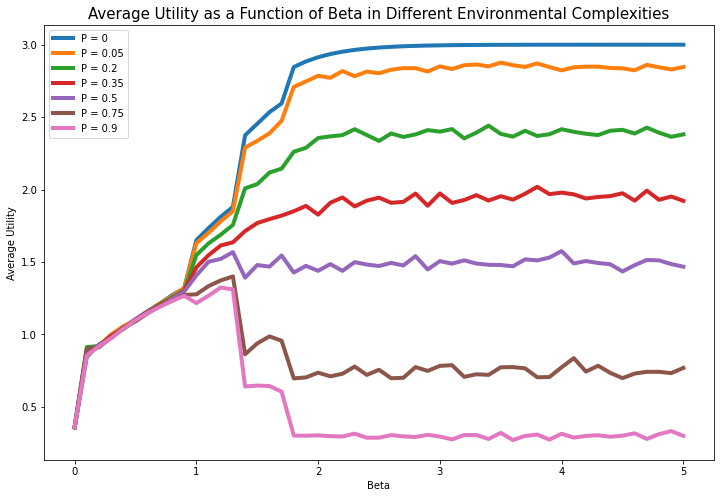

In [ ]:
plt.figure(figsize=(12,8))
for i,u in enumerate(uts_probs1):
  plt.plot(betas1, list(zip(*u))[0], label='P = ' + str(np.round(mis_stat1[i],2)), linewidth=4)
  
plt.xlabel('Beta')
plt.ylabel('Average Utility')
plt.legend(loc='best')
plt.title('Average Utility as a Function of Beta in Different Environmental Complexities', fontsize=15)
plt.show()

Print multiple trajectories for each condition

In [ ]:
samples = 5
uts_probs1_2 = [[[evolve_environment(pa_init, beta, U_pre, p_w, m_s, mis_cat, iterations) for beta in betas1] for s in range(samples)] for m_s in mis_stat1]

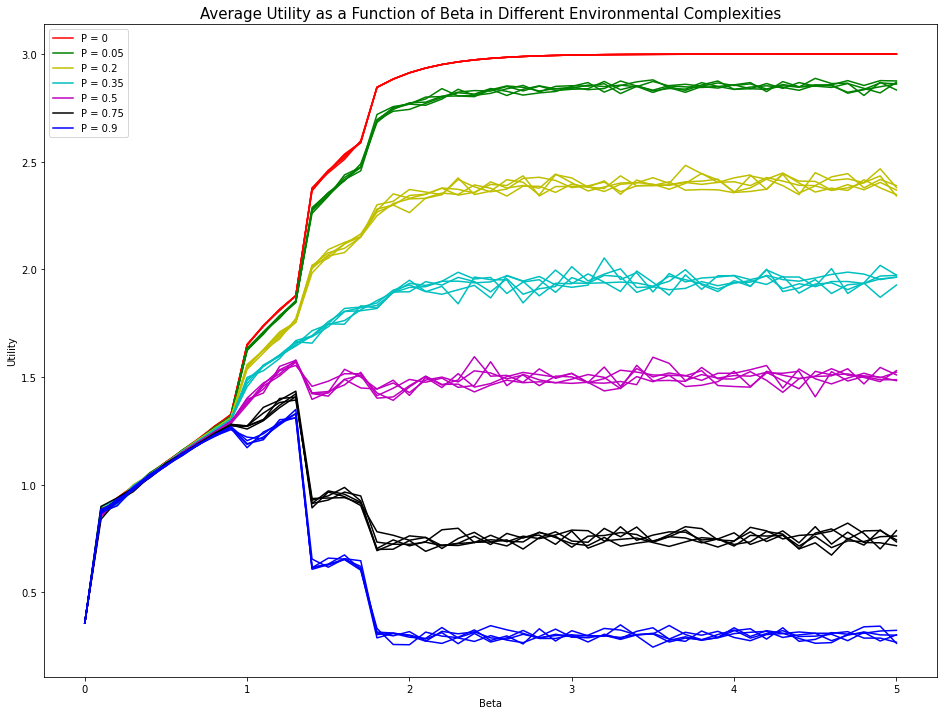

In [ ]:
plt.figure(figsize=(16,12))
colors = ['r', 'g', 'y', 'c', 'm', 'k', 'b']
for i,u in enumerate(uts_probs1_2):
  seen = False
  for x in u:
    if not seen:
      plt.plot(betas1, list(zip(*x))[0], label='P = ' + str(np.round(mis_stat1[i],2)), color=colors[i])
      seen = True
    elif seen:
      plt.plot(betas1, list(zip(*x))[0], color=colors[i])

plt.title('Average Utility as a Function of Beta in Different Environmental Complexities', fontsize=15)
plt.xlabel('Beta')
plt.ylabel('Utility')
plt.legend(loc='best')
plt.show()

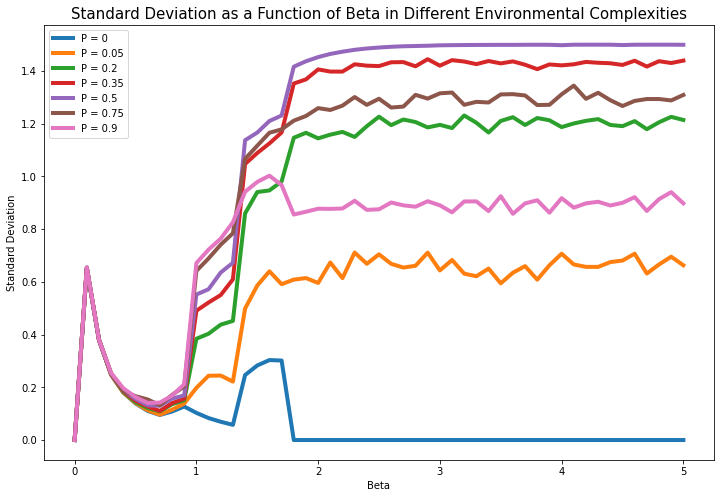

In [ ]:
plt.figure(figsize=(12,8))
for i,u in enumerate(uts_probs1):
  plt.plot(betas1, list(zip(*u))[1], label='P = ' + str(np.round(mis_stat1[i],2)), linewidth=4)

plt.title('Standard Deviation as a Function of Beta in Different Environmental Complexities', fontsize=15)
plt.xlabel('Beta')
plt.ylabel('Standard Deviation')
plt.legend(loc='best')
plt.show()

Again, print multiple trajectories for each condition

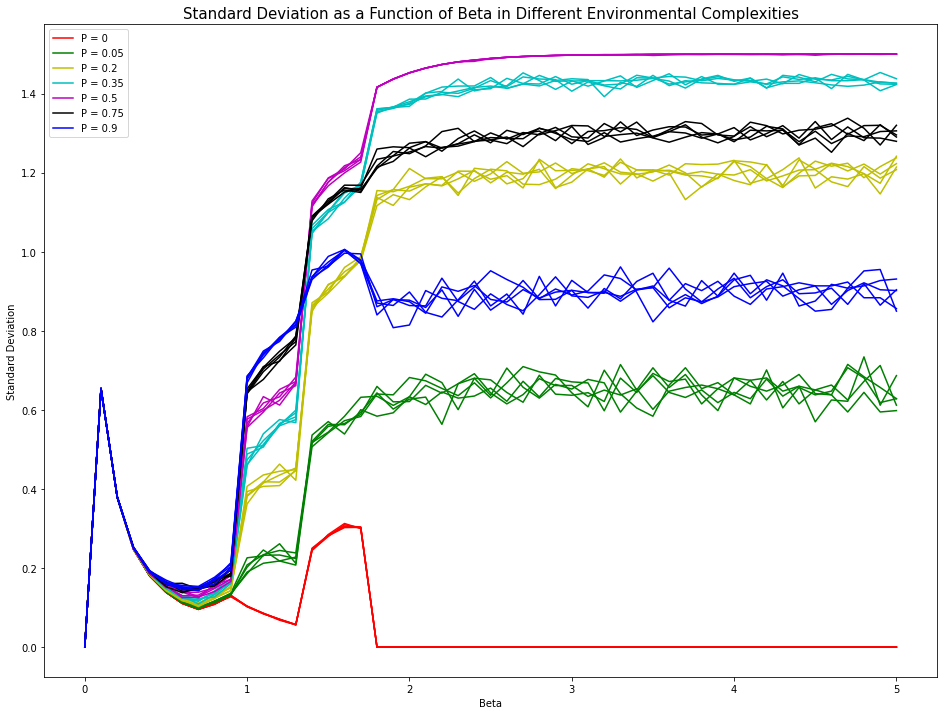

In [ ]:
plt.figure(figsize=(16,12))
colors = ['r', 'g', 'y', 'c', 'm', 'k', 'b']
for i,u in enumerate(uts_probs1_2):
  seen = False
  for x in u:
    if not seen:
      plt.plot(betas1, list(zip(*x))[1], label='P = ' + str(np.round(mis_stat1[i],2)), color=colors[i])
      seen = True
    elif seen:
      plt.plot(betas1, list(zip(*x))[1], color=colors[i])

plt.title('Standard Deviation as a Function of Beta in Different Environmental Complexities', fontsize=15)
plt.xlabel('Beta')
plt.ylabel('Standard Deviation')
plt.legend(loc='best')
plt.show()

Main policies: 

- $beta=0.5$: supercategory
- $beta=1.3$: category
- $beta=2$: specific item

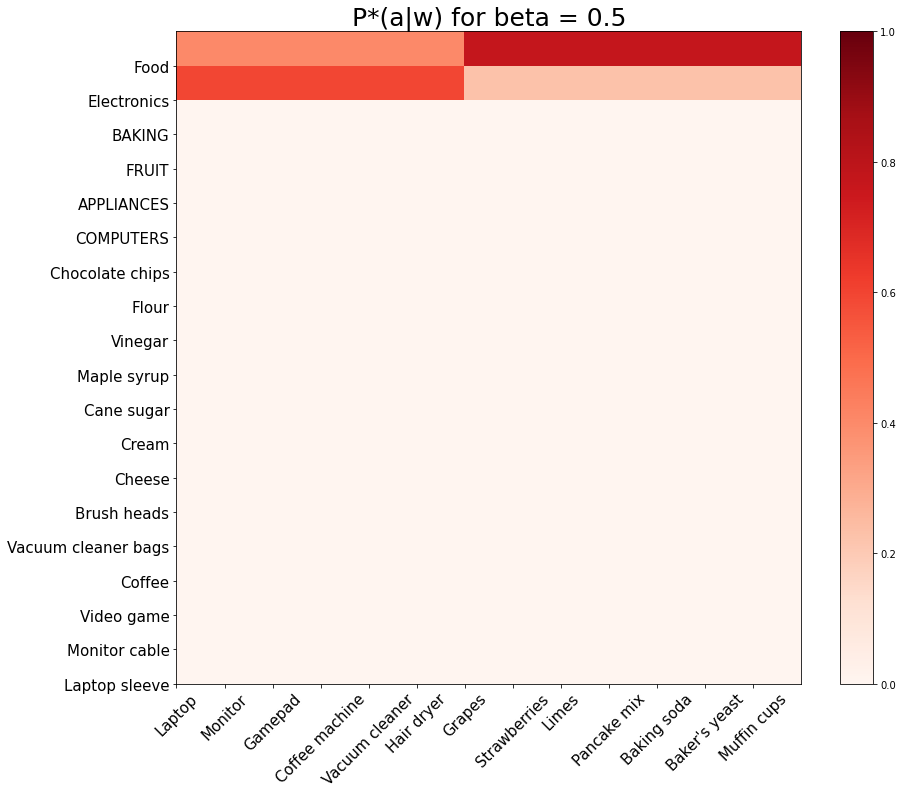

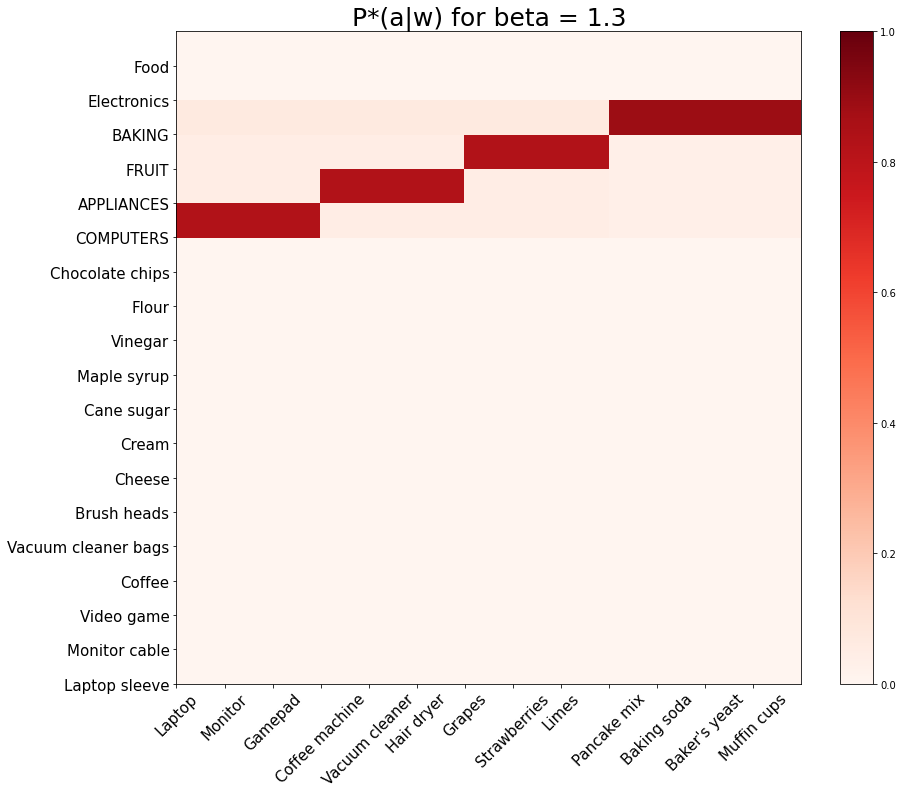

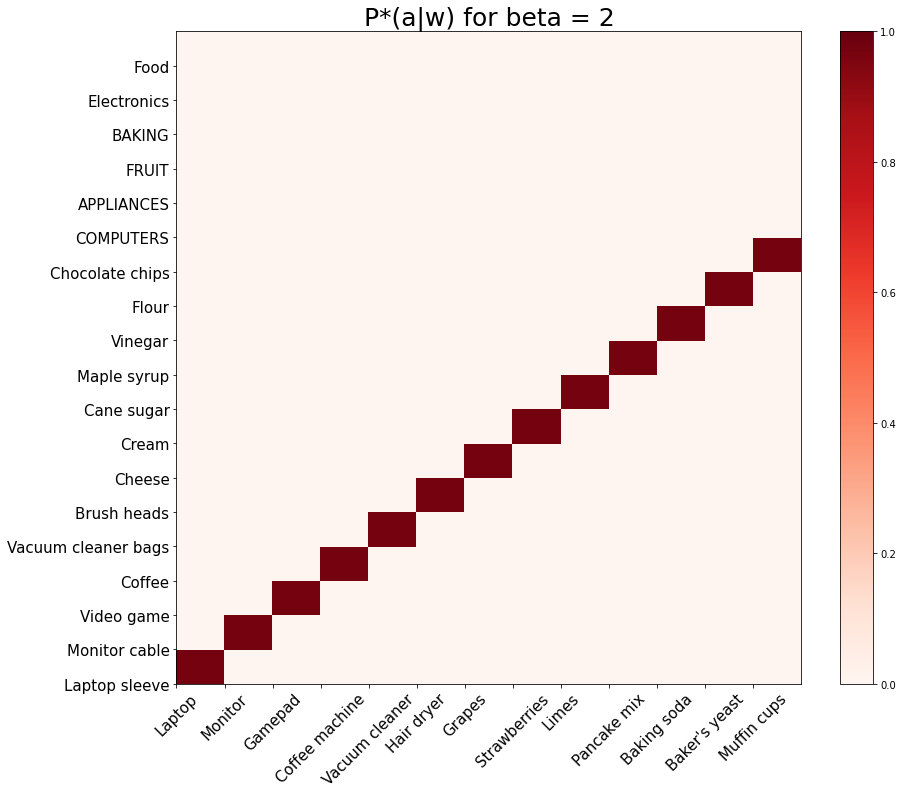

In [ ]:
for beta in [0.5, 1.3, 2]:

  code_book, prior = Blahut_Arimato(pa_init, beta, U_pre, p_w, maxiter)

  fig,ax = plt.subplots(figsize=(14,12))
  c2 = np.array(code_book).reshape(19, 13)
  pc2 = ax.pcolormesh(np.arange(0,14,1), np.arange(0,20,1), c2, vmin=0, vmax=1, cmap='Reds')

  ax.set_xticks(list(range(len(x_labels))))
  ax.set_xticklabels(x_labels, rotation=45, fontsize=15) 

  ax.set_yticks(list(range(len(y_labels))))
  ax.set_yticklabels(y_labels, fontsize=15)  

  fig.colorbar(pc2)
  plt.title('P*(a|w) for beta = ' + str(beta), fontsize=25)
  plt.show()

**Experiment 2**

In [ ]:
betas2 = [0.5, 1.3, 2]
mis_state2 = np.arange(0, 0.805, 0.05)
uts_probs2 = [[evolve_environment(pa_init, beta, U_pre, p_w, m_s, mis_cat, iterations) for m_s in mis_state2] for beta in betas2]

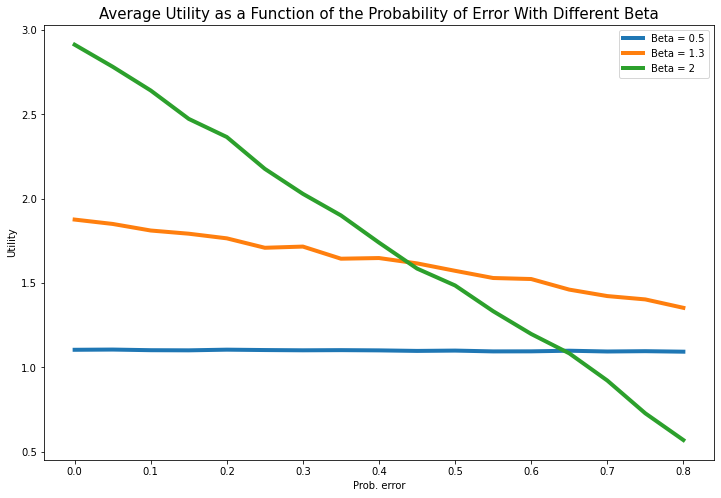

In [ ]:
plt.figure(figsize=(12,8))
for i,u in enumerate(uts_probs2):
  plt.plot(mis_state2, list(zip(*u))[0], label='Beta = ' + str(np.round(betas2[i],2)), linewidth=4)
  plt.xlabel('Prob. error')
  plt.ylabel('Utility')
  plt.legend(loc='best')

plt.title('Average Utility as a Function of the Probability of Error With Different Beta', fontsize=15)
plt.show()

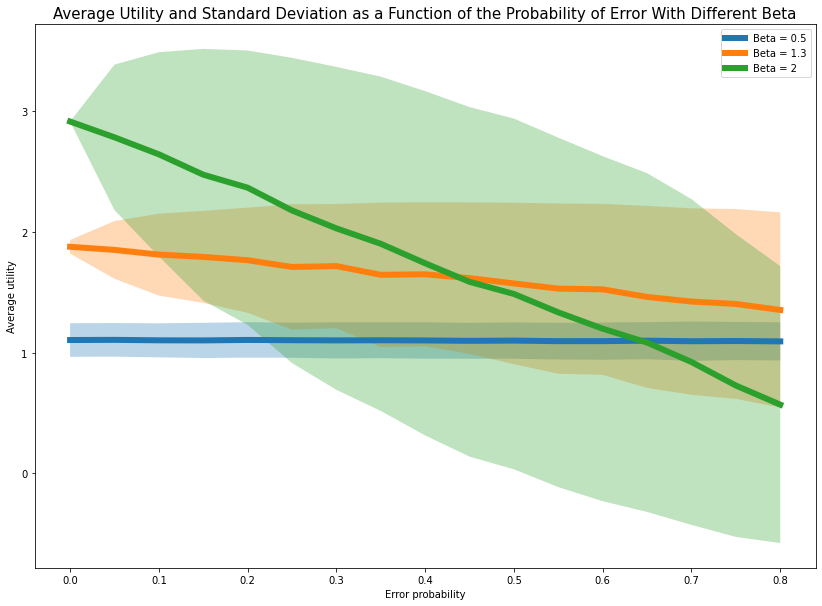

In [ ]:
plt.figure(figsize=(14,10))
for i,u in enumerate(uts_probs2):
  plt.plot(mis_state2, list(zip(*u))[0], label='Beta = ' + str(np.round(betas2[i],2)), linewidth=6)
  plt.fill_between(mis_state2, np.array(list(zip(*u))[0])-np.array(list(zip(*u))[1]), np.array(list(zip(*u))[0])+np.array(list(zip(*u))[1]), alpha=0.3)

plt.title('Average Utility and Standard Deviation as a Function of the Probability of Error With Different Beta', fontsize=15)
plt.xlabel('Error probability')
plt.ylabel('Average utility')
plt.legend(loc='best')
plt.show()

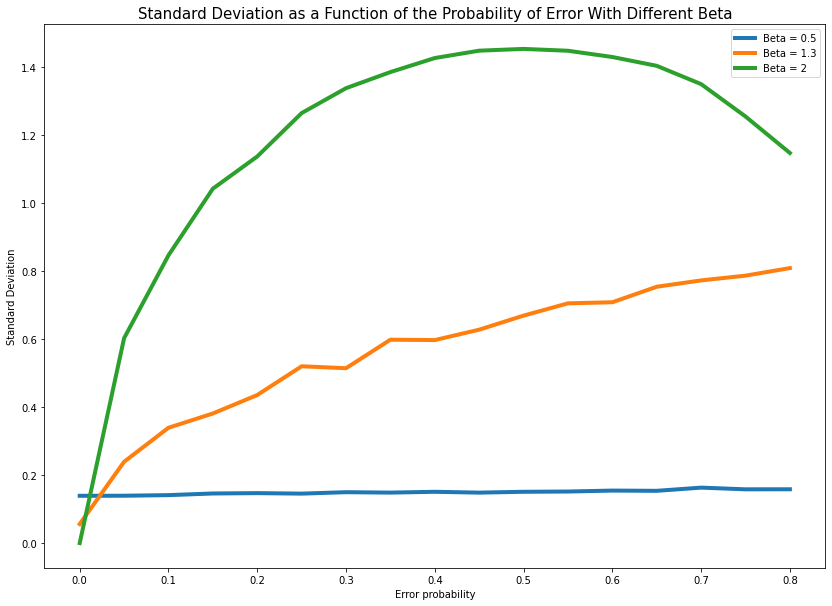

In [ ]:
plt.figure(figsize=(14,10))
for i,u in enumerate(uts_probs2):
  plt.plot(mis_state2, list(zip(*u))[1], label='Beta = ' + str(np.round(betas2[i],2)), linewidth=4)

plt.title('Standard Deviation as a Function of the Probability of Error With Different Beta', fontsize=15)
plt.xlabel('Error probability')
plt.ylabel('Standard Deviation')
plt.legend(loc='best')
plt.show()